### Author: William C Francis (willcf)
##Solution 2
### (i)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


####Downloading the dataset

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

### Creating x_train and y_train with 1000 images from each class and binarizing the pixels

In [ ]:
count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=1000):
        idx = np.append(idx, i)
        
y_train = ytrain[idx.astype('int')]
x_train_pre = xtrain[idx.astype('int')]

### Resizing the images from 28x28 to 14x14

In [ ]:
r,_,_ = x_train_pre.shape
x_train = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_train_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_train[i] = a

r,_,_ = x_val_pre.shape
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a

### Binarizing 

In [ ]:
x_train = np.where(x_train > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)

### Creating dataloaders

In [ ]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)

###(ii)
### Variational Auto Encoder model

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE()
if torch.cuda.is_available():
    model.cuda()

### Defining loss, optimizer and LR scheduler

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, verbose=True)

def loss_function(y, x, mu, std): 
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

### Training and Validating

In [ ]:
count=0
err_l, kld_l, n_wu, testl, update = [], [], [], [], []
for epoch in range(1, 20):
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        data = data.cuda()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          model.eval()
          a, _ = next(iter(testloader))
          a = a.cuda()
          trecon, tmu, tstd = model(a)
          tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
          testl.append(terr/100)
          update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.cuda()
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld
    
    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

====> Epoch: 1 Average loss: -53.0435
====> Test set loss: -42.5996
====> Epoch: 2 Average loss: -40.6272
====> Test set loss: -38.2108
====> Epoch: 3 Average loss: -37.6437
====> Test set loss: -36.7666
====> Epoch: 4 Average loss: -36.5402
====> Test set loss: -36.1269
====> Epoch: 5 Average loss: -35.8155
====> Test set loss: -35.5091
====> Epoch: 6 Average loss: -35.3183
====> Test set loss: -35.1126
====> Epoch: 7 Average loss: -34.8094
====> Test set loss: -34.6588
====> Epoch: 8 Average loss: -34.4826
====> Test set loss: -34.6813
====> Epoch: 9 Average loss: -34.1587
====> Test set loss: -34.1253
====> Epoch: 10 Average loss: -33.8791
====> Test set loss: -33.9171
====> Epoch: 11 Average loss: -33.6951
====> Test set loss: -33.8405
====> Epoch: 12 Average loss: -33.4680
====> Test set loss: -33.5765
====> Epoch: 13 Average loss: -33.2435
====> Test set loss: -33.3177
====> Epoch: 14 Average loss: -33.0651
====> Test set loss: -33.2091
====> Epoch: 15 Average loss: -32.9306
====

### (iii) Plotting the first and second term of ELBO as a function of weight updates

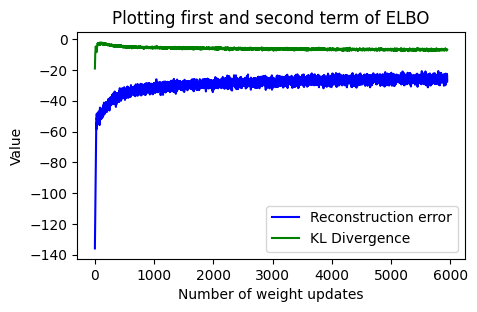

In [ ]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()
    

### (iv) 
### Visualizing input and output from the VAE from training set

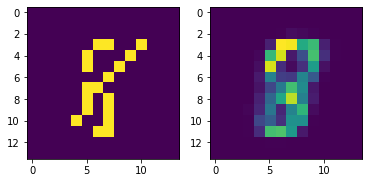

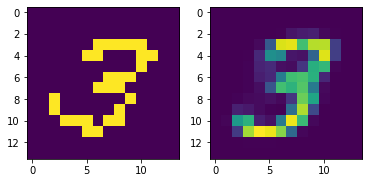

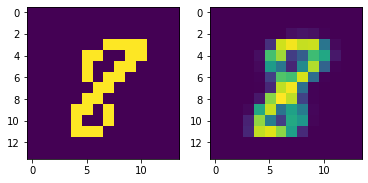

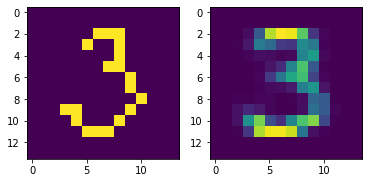

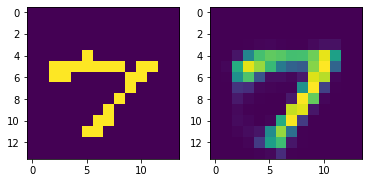

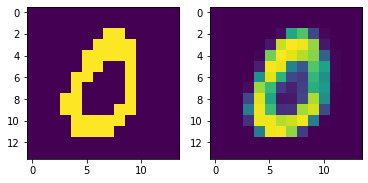

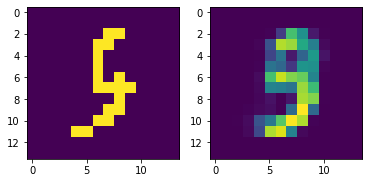

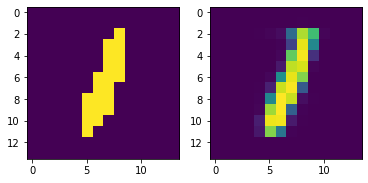

In [ ]:
model.eval()
for i in range(8):
  a,t = next(iter(trainloader))
  a = a.cuda()
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

### Visualizing input and output of the VAE from validation set

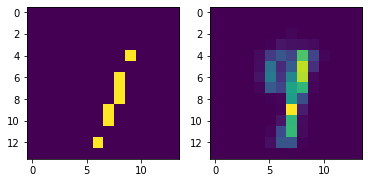

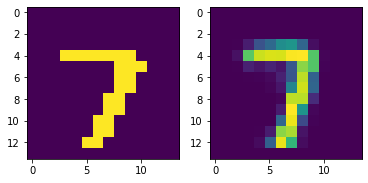

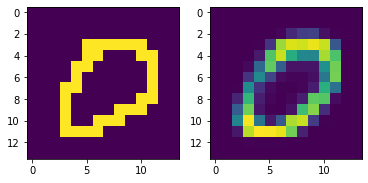

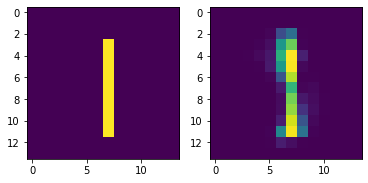

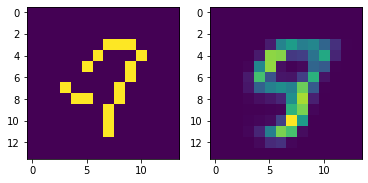

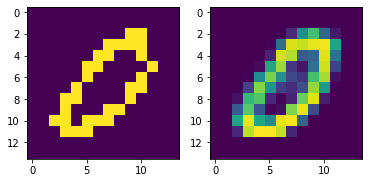

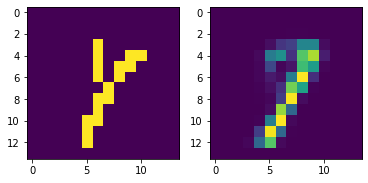

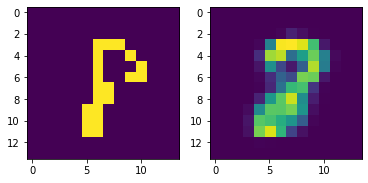

In [ ]:
model.eval()
for i in range(8):
  a,t = next(iter(testloader))
  a = a.cuda()
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

### (v)
### Synthesizing MNIST images from a Standard Gaussian Distribution

tensor([0.8694, 0.1257, 0.9046, 0.5266, 0.0294, 1.1379, 0.4387, 1.3595],
       device='cuda:0')
tensor([-0.3536, -0.7256,  1.2019,  0.6864,  2.0223,  0.1499, -1.0983, -0.6070],
       device='cuda:0')
tensor([-0.6419, -1.6500, -1.5856,  0.3711, -1.7955,  0.6540,  1.2691,  0.3070],
       device='cuda:0')
tensor([-1.2568,  0.6815,  0.4568,  0.7782, -0.1277, -0.2815,  0.7612,  0.8144],
       device='cuda:0')
tensor([-0.1773, -1.2371,  0.1835, -0.4513,  0.9493, -0.6720, -2.3180, -0.0734],
       device='cuda:0')
tensor([-1.0281, -0.3765,  0.2913,  0.7613, -1.1444,  0.8721,  1.0936,  0.9298],
       device='cuda:0')
tensor([ 0.4260, -0.5550, -0.1133, -1.8509,  1.1628,  0.1949, -1.0438,  1.1473],
       device='cuda:0')
tensor([-1.3624,  0.6229, -0.7229, -0.8347,  0.0666, -0.0252, -0.5792,  0.3448],
       device='cuda:0')


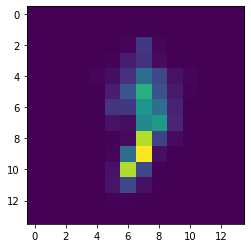

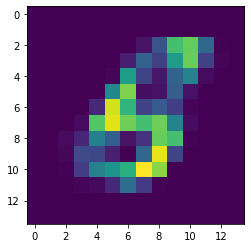

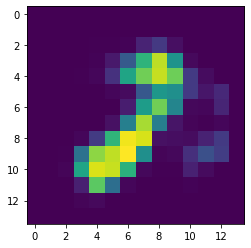

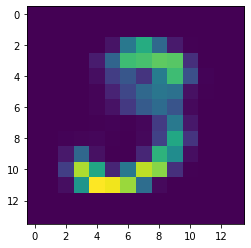

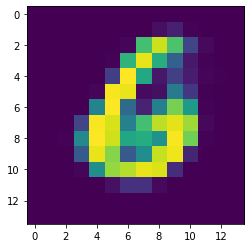

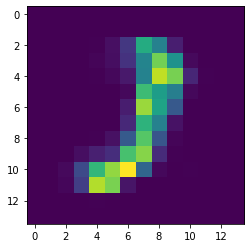

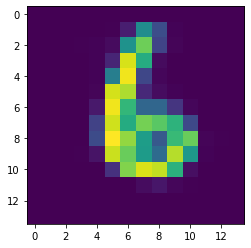

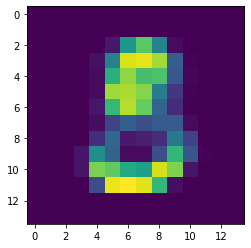

In [ ]:

for i in range(8):
  
  x = np.random.normal(0,1, 8)
  x= x.astype(np.float32)
  x=torch.from_numpy(x)
  x= x.cuda()
  recon = model.decoder(x)
  b = recon.reshape((14,14))
  print(x)
  f, axarr = plt.subplots(1) 
  axarr.imshow(b.detach().cpu().numpy())

### (vi)
### Comparing the reconstruction log likelihood term in ELBO on Training vs Validation set

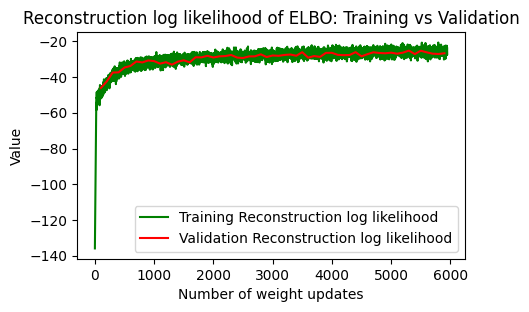

In [ ]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(err_l, 'g', label='Training Reconstruction log likelihood')
plt.plot(update, testl, 'r', label='Validation Reconstruction log likelihood')
plt.title('Reconstruction log likelihood of ELBO: Training vs Validation')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()